In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


/var/folders/53/y7vhv91s5wjg128t3djpb4t80000gn/T/ipykernel_11662/1526636886.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()


most_recent_date

'2017-08-23'

In [15]:
most_recent_date_pd = pd.to_datetime(most_recent_date)
most_recent_date_dt = most_recent_date_pd.to_pydatetime()


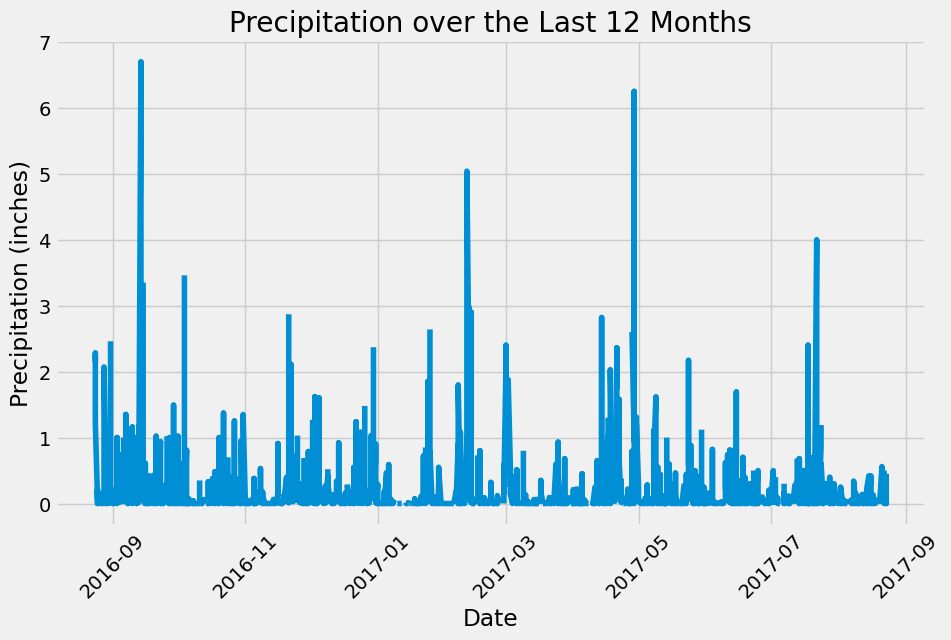

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date_dt - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(query, columns=['Date', 'Precipitation'])


# Sort the dataframe by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Precipitation'], linestyle='-')
plt.title('Precipitation over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.show()

In [19]:
df['Precipitation'].describe()


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations_query = (
    session.query(Station.station, func.count(Measurement.station))
    .join(Measurement, Station.station == Measurement.station)
    .group_by(Station.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

active_stations_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = session.query(func.max(Measurement.station)).scalar()
temperature_stats = (
    session.query(
        func.min(Measurement.tobs).label('min_temp'),
        func.max(Measurement.tobs).label('max_temp'),
        func.avg(Measurement.tobs).label('avg_temp')
    )
    .filter(Measurement.station == most_active_station_id)
    .all()
)

temperature_stats


[(56.0, 85.0, 74.5436493068565)]

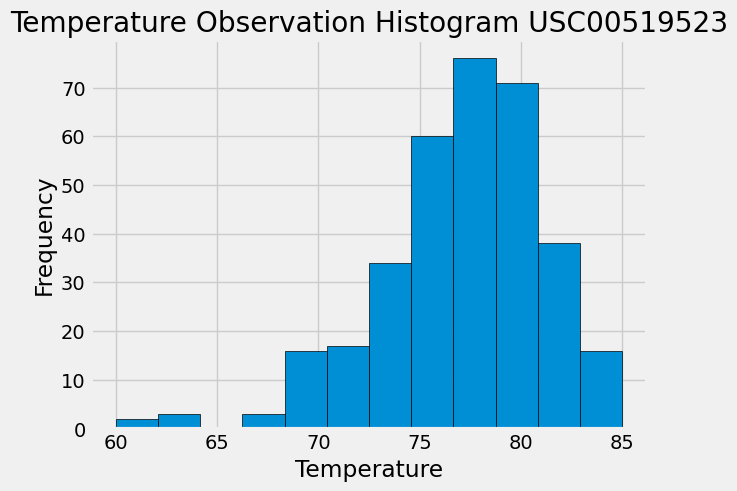

In [28]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Find the most recent date in the data set
most_recent_date_str = session.query(func.max(Measurement.date)).scalar()
most_recent_date = pd.to_datetime(most_recent_date_str)

most_recent_date_dt = most_recent_date.to_pydatetime()

# Calculate the date one year from the most recent date
one_year_ago = most_recent_date_dt - dt.timedelta(days=365)

# Get the ID of the most active station
most_active_station_id = session.query(func.max(Measurement.station)).scalar()

# Query to retrieve the last 12 months of temperature observation data for this station
temperature_data_query = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

# Convert the query results to a DataFrame
temperature_data_df = pd.DataFrame(temperature_data_query, columns=['Temperature'])

# Plot the histogram of the temperature data
plt.hist(temperature_data_df['Temperature'], bins=12, edgecolor='black')
plt.title(f'Temperature Observation Histogram {most_active_station_id}')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Close Session

In [29]:
# Close Session
session.close()